# Task 2: Visualize and cluster the data

### **Importing and loading**
We first import all the necessary packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from datetime import datetime
import seaborn as sns
from plotly.subplots import make_subplots
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


We load the cleaned data and remove unecessary columns for Task 2. The data is stored in a pandas dataframe

In [ ]:
df_raw = pd.read_csv('clean_data.csv')
df_raw.drop(['Unnamed: 0','hospitalized_new', 'hospitalized_cumulative'], 
              axis=1, inplace=True)

feature_names = df_raw.filter(regex='symptom:*', axis=1).columns
df_raw[feature_names] = df_raw.groupby('open_covid_region_code').transform(lambda x: (x / x.mean()))[feature_names]

# Remove the 'US-' prefix at the beginning of every state code
df_raw['open_covid_region_code'] = df_raw['open_covid_region_code'].str.replace('US-', '')
df_raw = df_raw.fillna(0)
df_raw

,open_covid_region_code,date,symptom:Adrenal crisis,symptom:Ageusia,symptom:Allergic conjunctivitis,symptom:Amenorrhea,symptom:Angular cheilitis,symptom:Anosmia,symptom:Aphonia,symptom:Asphyxia,symptom:Atheroma,symptom:Auditory hallucination,symptom:Balance disorder,symptom:Beau's lines,symptom:Burning Chest Pain,symptom:Cataplexy,symptom:Chorea,symptom:Cleft lip and cleft palate,symptom:Clouding of consciousness,symptom:Crackles,symptom:Crepitus,symptom:Cyanosis,symptom:Depersonalization,symptom:Dysautonomia,symptom:Dysgeusia,symptom:Dyspareunia,symptom:Epiphora,symptom:Esophagitis,symptom:Facial swelling,symptom:Fibrocystic breast changes,symptom:Focal seizure,symptom:Gastroparesis,symptom:Gingival recession,symptom:Globus pharyngis,symptom:Hemolysis,symptom:Hemoptysis,symptom:Hepatic encephalopathy,symptom:Hepatotoxicity,symptom:Hydrocephalus,symptom:Hypercalcaemia,...,symptom:Hypersomnia,symptom:Hyperventilation,symptom:Hypochondriasis,symptom:Hypomania,symptom:Laryngitis,symptom:Male infertility,symptom:Mitral insufficiency,symptom:Muscle atrophy,symptom:Myoclonus,symptom:Nasal polyp,symptom:Neck mass,symptom:Neutropenia,symptom:Night terror,symptom:Nocturnal enuresis,symptom:Nystagmus,symptom:Onychorrhexis,symptom:Papule,symptom:Pericarditis,symptom:Petechia,symptom:Photophobia,symptom:Polydipsia,symptom:Polyuria,symptom:Ptosis,symptom:Pulmonary edema,symptom:Rectal pain,symptom:Rectal prolapse,symptom:Rheum,symptom:Rumination,symptom:Sensitivity to sound,symptom:Shallow breathing,symptom:Spasticity,symptom:Stomach rumble,symptom:Stridor,symptom:Subdural hematoma,symptom:Tachypnea,symptom:Tenderness,symptom:Trichoptilosis,symptom:Urinary urgency,symptom:Ventricular fibrillation,symptom:Viral pneumonia
0,AK,2020-03-30,1.008820,2.414010,3.195506,0.866136,0.000000,2.193437,0.0,1.086937,0.932399,0.861849,1.023843,1.181117,1.639334,1.584205,1.117215,0.893980,1.145470,0.000000,0.000000,1.161188,0.932362,0.000000,1.463130,0.753769,1.498084,1.132173,0.711224,1.120659,0.636790,0.620433,0.885394,1.214531,0.969421,1.316065,1.452900,1.465628,0.000000,1.040894,...,1.076787,1.241670,1.599324,1.145133,0.000000,1.137242,1.449024,0.892594,0.962504,1.254703,0.736440,0.918992,0.810603,1.157693,0.798551,1.113649,1.193403,0.994421,1.353188,1.278541,2.268531,0.000000,0.783107,1.613054,0.000000,0.792407,0.000000,1.042781,0.833145,2.628039,0.000000,0.845629,2.468267,0.982151,1.273831,0.821861,1.188429,2.206005,1.214692,2.958077
1,AK,2020-04-06,1.134922,1.980242,0.000000,1.096632,1.811805,0.779505,0.0,0.878471,1.424567,0.000000,1.009818,0.911094,1.383728,0.000000,1.518684,0.905660,0.000000,1.595273,0.000000,1.328738,0.670996,0.000000,1.207427,0.839023,0.000000,1.504394,0.603061,0.904274,0.871287,1.272792,0.636440,1.188022,1.089669,1.071370,1.149548,1.446379,1.542010,1.207010,...,1.224165,0.904634,0.810263,1.108850,6.000000,0.748501,0.000000,0.776851,0.000000,1.376266,0.867818,0.815086,0.964168,0.816050,0.861023,0.626427,0.647676,0.879225,0.866507,1.425431,1.731469,0.692169,1.139690,1.454545,2.516990,0.849758,1.224155,1.039343,0.844419,1.716370,1.136543,1.351685,0.000000,1.197745,0.949959,0.761564,1.111290,0.000000,0.000000,3.041923
2,AK,2020-04-13,0.702571,0.000000,0.000000,0.806228,1.673225,1.225101,0.0,0.955849,1.069662,1.251922,0.821879,1.111251,1.499039,1.234578,1.032897,0.840970,1.533009,1.601920,1.425494,1.007423,1.321083,0.000000,0.827586,1.120776,0.000000,0.865414,1.041837,0.985752,1.078687,1.086556,1.181529,0.891507,1.108264,1.220171,0.996275,1.208524,1.401977,1.016510,...,1.488382,0.890846,0.928253,1.092035,0.000000,0.949367,0.000000,0.848455,1.319425,0.000000,1.059462,0.966327,0.933455,0.954123,1.027614,1.357259,0.680660,0.963899,0.891649,0.000000,0.000000,1.243741,1.203898,1.917638,0.000000,1.088045,1.183897,0.845684,1.119504,1.655592,1.477506,0.842986,0.000000,1.039925,0.810172,0.925936,1.037364,0.000000,0.000000,0.000000
3,AK,2020-04-20,0.833177,0.000000,2.804494,1.208326,0.000000,0.000000,0.0,0.832044,1.615004,1.300681,1.112669,1.

### **Part I: Visualization of search trends**
We want to visualize the popularity of various symptoms across different regions over time. We decided to visualize the most common symptoms based off the results of permutation feature importance.

We made a graph of the weekly average county popularity of the entire country for a given symptom over time. This will help us visualize overall popularity of a given symptom over time.

(0.0, 1.5)

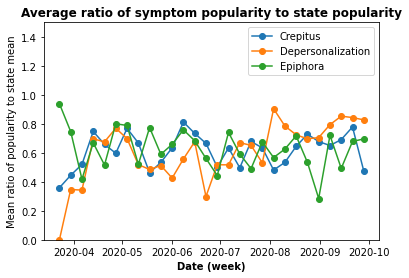

In [ ]:
df_week = df_raw[['date', 'symptom:Crepitus', 'symptom:Depersonalization', 'symptom:Epiphora', 'symptom:Nasal polyp', 'symptom:Rumination']]
df_week_mean = df_week.groupby('date', as_index=False)['symptom:Crepitus', 'symptom:Depersonalization', 'symptom:Epiphora', 'symptom:Nasal polyp', 'symptom:Rumination'].mean()
df_week_sd = df_week.groupby('date', as_index=False)['symptom:Crepitus', 'symptom:Depersonalization', 'symptom:Epiphora', 'symptom:Nasal polyp', 'symptom:Rumination'].std()
df_week_mean['date'] = pd.to_datetime(df_week_mean['date'])

plt.plot(df_week_mean['date'], df_week_mean['symptom:Crepitus'], marker = 'o')
plt.plot(df_week_mean['date'], df_week_mean['symptom:Depersonalization'], marker = 'o')
plt.plot(df_week_mean['date'], df_week_mean['symptom:Epiphora'], marker = 'o')
plt.xlabel('Date (week)', fontweight='bold')
plt.ylabel('Mean ratio of popularity to state mean')
plt.title('Average ratio of symptom popularity to state popularity', fontweight='bold')
plt.legend(['Crepitus', 'Depersonalization', 'Epiphora'])
plt.autoscale()
plt.ylim((0,1.5))

We plot the graph of the weekly average county popularity of the entire country for fatigue searches over time. This figure was not part of the report (there wasn't enough space).

In [ ]:
# Choropleth map for searches for coughing. 
df_crepitus = df_raw[['open_covid_region_code', 'date', 'symptom:Crepitus']]
df_crepitus = df_crepitus[df_crepitus['date'].str.match('2020-03-30')]

fig = go.Figure(data=go.Choropleth(
    locations=df_crepitus['open_covid_region_code'], # Spatial coordinates
    z=df_crepitus['symptom:Crepitus'].astype(float), # Data to be color-coded
    locationmode='USA-states',
    colorscale='rdbu',
    reversescale = True,
    marker_line_color='white', # line markers between states
    colorbar_title='Ratio of county popularity to county symptom mean ',
    zmax = 1,
    zmin=0)
)

fig.data[0].colorbar.titleside = 'right'
# Configure the layout and display the figure
fig.update_layout(
    # title_text='Popularity of Crepitus searches on the week of 2020-09-28',
    geo = dict(
        scope='usa',
        projection=go.layout.geo.Projection(type = 'albers usa'),
        showlakes=True, # lakes
        lakecolor='rgb(255, 255, 255)'),
   margin=dict(l=0, r=1100, t=90, b=50)
)

fig.show()

### **Part II: Principal Component Analysis (PCA)**

We would like to reduce data dimensionality using PCA. We first need to determine the minimum number of PCs required to sufficiently characterize the variance in the data.

Text(0, 0.5, 'Cumulative variance ratio')

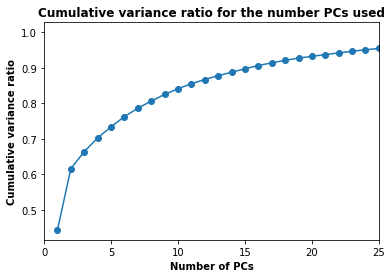

In [ ]:
# Remove all data no pertaining to symptoms
df_symp = df_raw.loc[:, df_raw.columns.str.startswith('symptom')]

# Perform PCA
pca = PCA()
pca.fit(df_symp)
plt.plot([i for i in range(1, len(pca.explained_variance_ratio_)+1)], np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlim((0, 25))
plt.title('Cumulative variance ratio for the number PCs used', fontweight='bold')
plt.xlabel('Number of PCs', fontweight='bold')
plt.ylabel('Cumulative variance ratio', fontweight='bold')

We see that 15 principle components is sufficient to explain 90% of the variance. 

In [ ]:
pca = PCA(n_components=15)
df_symp_reduce = pca.fit_transform(df_symp)
df_symp_reduce.shape

(228, 15)

We will display the data in a 3D plot for visualization. The three plots represent various axes combinations.

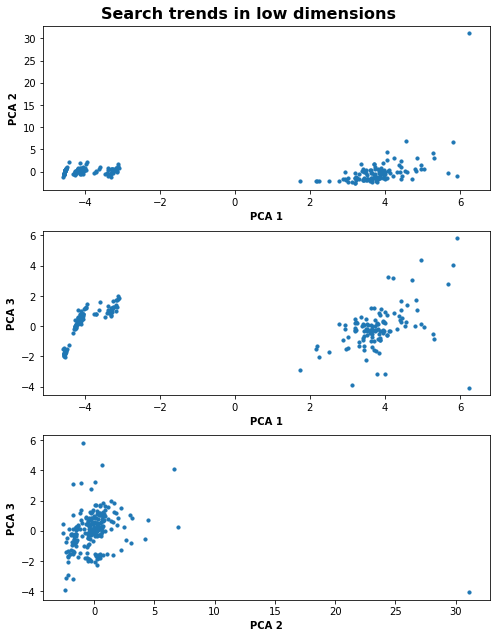

In [ ]:
plt.subplots(3,1,figsize=(7,9))
plt.suptitle('Search trends in low dimensions', fontsize=16, fontweight='bold')

plt.subplot(3,1,1)
plt.scatter(df_symp_reduce[:,0], df_symp_reduce[:,1], s=10)
# plt.title('Search trends in low dimensions')
plt.xlabel('PCA 1', fontweight='bold')
plt.ylabel('PCA 2', fontweight='bold')

plt.subplot(3,1,2)
plt.scatter(df_symp_reduce[:,0], df_symp_reduce[:,2], s=10)
plt.xlabel('PCA 1', fontweight='bold')
plt.ylabel('PCA 3', fontweight='bold')

plt.subplot(3,1,3)
plt.scatter(df_symp_reduce[:,1], df_symp_reduce[:,2], s=10)
plt.xlabel('PCA 2', fontweight='bold')
plt.ylabel('PCA 3', fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(top=0.95)

### **Part III: K-means clustering**
We will perform KMeans clustering on both the high and low dimensional data. We will test multiple value of k to determine the value k that minimizes the cost.

Text(0, 0.5, 'Sum of squared distances')

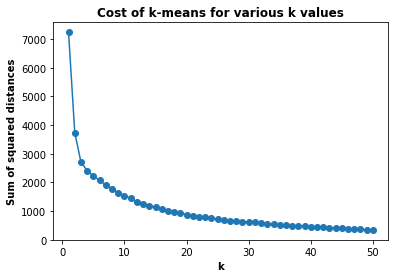

In [ ]:
k_list = range(1,51)
k_cost = [0. for i in range(0,50)]

for i in k_list:
  kmeans_low = KMeans(n_clusters=i, init='k-means++', random_state=1)
  kmeans_low.fit(df_symp_reduce)
  k_cost[i-1] = kmeans_low.inertia_

plt.plot(k_list, k_cost, marker='o')
plt.title('Cost of k-means for various k values', fontweight='bold')
plt.xlabel('k', fontweight='bold')
plt.ylabel('Sum of squared distances', fontweight='bold')



Based off the graph, it appears that the optimal k is approximately 3, where the 'elbow' bends. We will use k=3 as our hyperparameter for K-means. We fit both the high dimensional (all ~140 dimensions) and low dimensional data (3 dimensions. Both high and low dimensional data are fitted in order to show that the clustering in lower dimensions is consistent with the clustering in PCA-reduced data.

In [ ]:
kmeans_high = KMeans(n_clusters=3, init='k-means++', random_state=0)
kmeans_high.fit(df_symp)
y_pred_high = kmeans_high.predict(df_symp)

kmeans_low = KMeans(n_clusters=3, init='k-means++', random_state=0)
kmeans_low.fit(df_symp_reduce)
y_pred_low = kmeans_low.predict(df_symp_reduce)

Plot the high and low dimension clustering

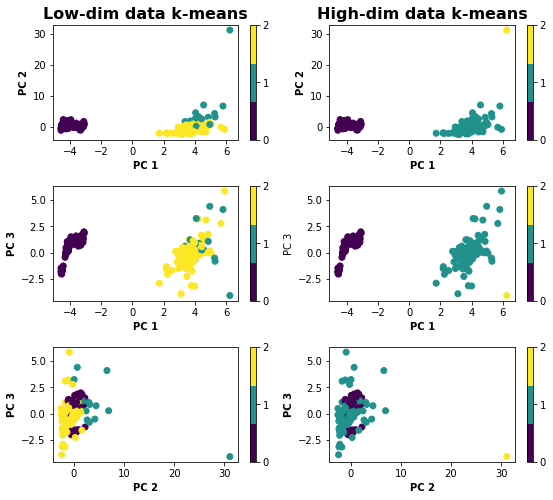

In [ ]:
plt.subplots(3,2,figsize=(8,7))

plt.subplot(3,2,1)
plt.scatter(df_symp_reduce[:,0], df_symp_reduce[:,1], c=y_pred_low, cmap=plt.cm.get_cmap('viridis', 3))
plt.colorbar(ticks=[0,1,2])
plt.xlabel("PC 1", fontweight='bold')
plt.ylabel("PC 2", fontweight='bold')
plt.title("Low-dim data k-means", fontsize=16, fontweight='bold')

plt.subplot(3,2,2)
plt.scatter(df_symp_reduce[:,0], df_symp_reduce[:,1], c=y_pred_high, cmap=plt.cm.get_cmap('viridis', 3))
plt.colorbar(ticks=[0,1,2])
plt.xlabel("PC 1", fontweight='bold')
plt.ylabel("PC 2", fontweight='bold')
plt.title("High-dim data k-means", fontsize=16, fontweight='bold')

plt.subplot(3,2,3)
plt.scatter(df_symp_reduce[:,0], df_symp_reduce[:,2], c=y_pred_low, cmap=plt.cm.get_cmap('viridis', 3))
plt.colorbar(ticks=[0,1,2])
plt.xlabel("PC 1", fontweight='bold')
plt.ylabel("PC 3", fontweight='bold')

plt.subplot(3,2,4)
plt.scatter(df_symp_reduce[:,0], df_symp_reduce[:,2], c=y_pred_high, cmap=plt.cm.get_cmap('viridis', 3))
plt.colorbar(ticks=[0,1,2])
plt.xlabel("PC 1", fontweight='bold')
plt.ylabel("PC 3")

plt.subplot(3,2,5)
plt.scatter(df_symp_reduce[:,1], df_symp_reduce[:,2], c=y_pred_low, cmap=plt.cm.get_cmap('viridis', 3))
plt.colorbar(ticks=[0,1,2])
plt.xlabel("PC 2", fontweight='bold')
plt.ylabel("PC 3", fontweight='bold')

plt.subplot(3,2,6)
plt.scatter(df_symp_reduce[:,1], df_symp_reduce[:,2], c=y_pred_high, cmap=plt.cm.get_cmap('viridis', 3))
plt.colorbar(ticks=[0,1,2])
plt.xlabel("PC 2", fontweight='bold')
plt.ylabel("PC 3", fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(top=0.95)

Based on visual inspection, it appears that the clustering remains consistent for both the raw and PCA-reduced data.

We were interested in seeing whether different clustering methods could produce similar results to k-means. Gaussian mixtures model the data as a combination of multiple Gaussian distributions. Normally this model is used to determine probabilistic memberships using responsibilities, but since we were interested in direct comparisons with k-means, we used the Gaussian mixture model with hard cluster membership (k=3).


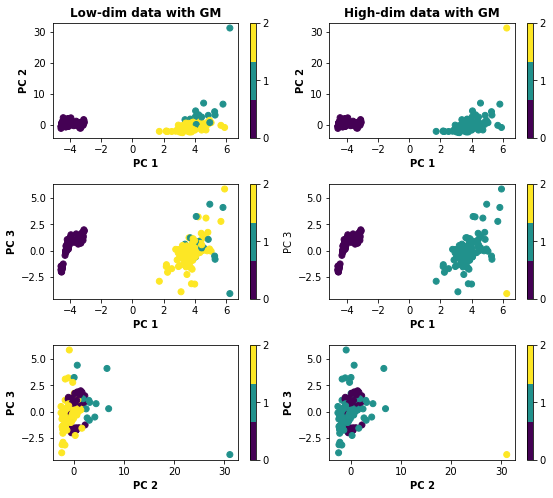

In [ ]:
gauss_mix_high = GaussianMixture(n_components=3, random_state=1)
gauss_mix_high.fit(df_symp)
y_pred_high = gauss_mix_high.predict(df_symp)

gauss_mix_low = GaussianMixture(n_components=3, random_state=1)
gauss_mix_low.fit(df_symp_reduce)
y_pred_low = gauss_mix_low.predict(df_symp_reduce)

plt.subplots(3,2,figsize=(8,7))

plt.subplot(3,2,1)
plt.scatter(df_symp_reduce[:,0], df_symp_reduce[:,1], c=y_pred_low, cmap=plt.cm.get_cmap('viridis', 3))
plt.colorbar(ticks=[0,1,2])
plt.xlabel("PC 1", fontweight='bold')
plt.ylabel("PC 2", fontweight='bold')
plt.title("Low-dim data with GM", fontsize=12, fontweight='bold')

plt.subplot(3,2,2)
plt.scatter(df_symp_reduce[:,0], df_symp_reduce[:,1], c=y_pred_high, cmap=plt.cm.get_cmap('viridis', 3))
plt.colorbar(ticks=[0,1,2])
plt.xlabel("PC 1", fontweight='bold')
plt.ylabel("PC 2", fontweight='bold')
plt.title("High-dim data with GM", fontsize=12, fontweight='bold')

plt.subplot(3,2,3)
plt.scatter(df_symp_reduce[:,0], df_symp_reduce[:,2], c=y_pred_low, cmap=plt.cm.get_cmap('viridis', 3))
plt.colorbar(ticks=[0,1,2])
plt.xlabel("PC 1", fontweight='bold')
plt.ylabel("PC 3", fontweight='bold')

plt.subplot(3,2,4)
plt.scatter(df_symp_reduce[:,0], df_symp_reduce[:,2], c=y_pred_high, cmap=plt.cm.get_cmap('viridis', 3))
plt.colorbar(ticks=[0,1,2])
plt.xlabel("PC 1", fontweight='bold')
plt.ylabel("PC 3")

plt.subplot(3,2,5)
plt.scatter(df_symp_reduce[:,1], df_symp_reduce[:,2], c=y_pred_low, cmap=plt.cm.get_cmap('viridis', 3))
plt.colorbar(ticks=[0,1,2])
plt.xlabel("PC 2", fontweight='bold')
plt.ylabel("PC 3", fontweight='bold')

plt.subplot(3,2,6)
plt.scatter(df_symp_reduce[:,1], df_symp_reduce[:,2], c=y_pred_high, cmap=plt.cm.get_cmap('viridis', 3))
plt.colorbar(ticks=[0,1,2])
plt.xlabel("PC 2", fontweight='bold')
plt.ylabel("PC 3", fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(top=0.95)

The clusters are nearly identical to the clusters generated using k-means. This gives us a stronger indication regarding the existence of these clusters present in this dataset. This result was not included in the report in the interest of saving space.